In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
DEBUG = "ALL"

In [2]:
class Ball:
    def __init__(self, team, label, loc):
        self.team = team
        self.label = label
        self.loc = loc

Threshold by color and mask

In [3]:
# order is blue, green, red
def mask_table(color_img):
    pixels = []
    for i in color_img:
        for j in i:
            pixels.append(j)
    pixels = np.array(pixels)
    bins = [0,100,150,255]
    hist, bins = np.histogramdd(pixels, bins=(bins, bins, bins))

    # find the highest histogram bin
    max_r, max_g, max_b, max_val = 0, 0, 0, 0
    for r in range(hist.shape[0]):
        for g in range(hist.shape[1]):
            for b in range(hist.shape[2]):
                if hist[r][g][b] > max_val:
                    max_val = hist[r][g][b]
                    (max_r, max_g, max_b) = r, g, b
    bins = bins[0]
    lower = np.array([bins[max_r], bins[max_g], bins[max_b]])
    upper = np.array([bins[max_r + 1], bins[max_g + 1], bins[max_b + 1]])
    # just get the pixels in the highest histogram bin
    mask = cv2.inRange(color_img, lower, upper)
    # fill in the holes
    kernel = np.ones((7, 7),np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=10)
    # dilation is grayscale, lets convert it to have three channels
    rgb_dilation = np.uint8(np.zeros((dilation.shape[0], dilation.shape[1], 3)))
    for i in range(rgb_dilation.shape[0]):
        for j in range(rgb_dilation.shape[1]):
            rgb_dilation[i][j][:] = dilation[i][j]

    res = cv2.bitwise_and(color_img, rgb_dilation)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    if DEBUG == "MASK" or DEBUG == "ALL":
        plt.imshow(res)
        plt.show()
    return res

In [4]:
def hough_circles(full_img, masked_image, output_file):
    cimg = full_img.copy()
    gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray)
    plt.show()
    alt = True
    if alt:
        h_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, param1=100, param2=0.6, dp=1.5, minRadius=10, maxRadius=16, minDist=5)
    else:
        h_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, param1=cv2.CV_64F, param2=40, dp=1.75, minRadius=11, maxRadius=16, minDist=5)
    if h_circles is None:
        print("no circles found")
        return []
    h_circles = np.uint16(np.around(h_circles))

    k = 0
    for i in h_circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
        k+=1

    if DEBUG == "CIRCLES" or DEBUG == "ALL":
        plt.title("Hough Circles")
        plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
        cv2.imwrite("circles.png", cimg)
    cv2.imwrite(output_file, cimg)
    
    return h_circles

In [5]:
def label_balls(color_img, hough_circs, output_file):
    ## get the pixel values of all the circles
    balls = []
    num_solids = 0
    num_stripes = 0
    if len(hough_circs) == 0:
        return balls
    for circle in hough_circs[0,:]:
        rad = circle[2]
        center_x = circle[1]
        center_y = circle[0]
        # iterate over the box containing the circle
        num_colored = 0
        num_white = 0
        num_black = 0
        for i in range(2*rad):
            for j in range(2*rad):
                tmp_x = center_x - rad + i
                tmp_y = center_y - rad + j
                # check that the point is actually in the circle
                if (tmp_x - center_x)**2 + (tmp_y - center_y)**2 < rad**2:
                    pix = color[tmp_x][tmp_y]
                    white_thresh = 100
                    black_thresh = 50
                    # the white pixels
                    if pix[0] > white_thresh and pix[1] > white_thresh and pix[2] > white_thresh:
                        num_white += 1
                    # the black pixels
                    elif pix[0] < black_thresh and pix[1] < black_thresh and pix[2] < black_thresh:
                        num_black += 1
                    else:
                        num_colored += 1
        total_pixels = num_white + num_black + num_colored
        # print(num_white / total_pixels)
        if total_pixels == 0:
            continue
        if num_white / total_pixels >= 0.95:
            ball = Ball(team=None, label="cue", loc=(center_y, center_x))
        elif num_black / total_pixels >= 0.8:
            ball = Ball(team=None, label="eight", loc=(center_y, center_x))
        elif num_white / total_pixels >= 0.25:
            ball = Ball(team="stripes", label=str(num_stripes), loc=(center_y, center_x))
            num_stripes += 1
        else:
            ball = Ball(team="solids", label=str(num_solids), loc=(center_y, center_x))
            num_solids += 1
        balls.append(ball)

    labeled_balls = color_img.copy()
    for b in balls:
        if b.team == 'solids': col = (0,255,0)
        if b.team == 'stripes': col = (255,0,255)
        if b.team == None: col = (255,150,0)
        cv2.putText(labeled_balls, b.team if b.team else b.label, (b.loc[0],b.loc[1]), cv2.FONT_HERSHEY_PLAIN, 1, col, 1)
        cv2.circle(labeled_balls,(b.loc[0],b.loc[1]),2,col,2)

    if DEBUG == "LABELS" or DEBUG == "ALL":
        plt.imshow(cv2.cvtColor(labeled_balls, cv2.COLOR_BGR2RGB))
    cv2.imwrite(output_file, labeled_balls)
    return balls

In [6]:
def contours(img):
    blurred = cv2.GaussianBlur(img,(7,7), sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,(7,7), sigmaX=0, sigmaY=0) 
    blurred = cv2.GaussianBlur(blurred,(7,7), sigmaX=0, sigmaY=0) 
    # blurred = cv2.GaussianBlur(blurred,(7,7), sigmaX=0, sigmaY=0) 
    # blurred = cv2.GaussianBlur(blurred,(7,7), sigmaX=0, sigmaY=0) 
    
    scharr_X = cv2.Scharr(blurred, cv2.CV_64F, 1, 0) 
    scharr_X_abs = np.uint8(np.absolute(scharr_X)) 
    scharr_Y = cv2.Scharr(blurred, cv2.CV_64F, 0, 1) 
    scharr_Y_abs = np.uint8(np.absolute(scharr_Y)) 
    scharr_XY_combined = cv2.bitwise_or(scharr_Y_abs,scharr_X_abs) 
    plt.imshow(scharr_XY_combined)
    cv2.imwrite("edges.png", scharr_XY_combined)
    plt.show()


    kernel = np.ones((5, 5),np.uint8)
    eroded = cv2.erode(scharr_XY_combined, kernel)
    eroded = cv2.dilate(scharr_XY_combined, kernel)
    plt.imshow(eroded)
    plt.show()
    # eroded = cv2.cvtColor(eroded, cv2.COLOR_RGB2GRAY)
    # plt.imshow(eroded)
    # plt.show()
    # ret, thresh = cv2.threshold(eroded, 190, 255, cv2.THRESH_BINARY)
    # plt.imshow(thresh)
    # plt.show()
    
    # output = cv2.connectedComponentsWithStats(eroded, 4, cv2.CV_32S)
    # print(output)
    # plt.imshow(output)
    # plt.show()
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # ret, thresh = cv2.threshold(gray, 90, 200, cv2.THRESH_TOZERO)
    # plt.imshow(thresh)
    # plt.show()
    
    # edged = cv2.cvtColor(scharr_XY_combined, cv2.COLOR_GRAY2RGB)
    # contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
    # plt.imshow(img)
    return eroded

In [20]:
def get_table_edges(masked_image, original_image):
    msk_img = masked_image.copy()
    org_img = original_image.copy()
    grayscale = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    msk_lines = np.zeros((original_image.shape[0], original_image.shape[1],original_image.shape[2]), dtype=np.uint8)
    img_blur = cv2.GaussianBlur(grayscale, (3,3), 0) 
    edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
    lines = cv2.HoughLines(edges,1,np.pi/180,190,None,0,0)
    if lines is not None:
            for i in range(0, len(lines)):
                rho = lines[i][0][0]
                theta = lines[i][0][1]
                a = math.cos(theta)
                b = math.sin(theta)
                x0 = a * rho
                y0 = b * rho
                #print(x0, y0)
                pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
                pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
                #print (pt1, pt2)
                cv2.line(msk_img, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)
                cv2.line(org_img, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)
                cv2.line(msk_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)

    plt.title('Only show the masked region')
    plt.imshow(msk_img)
    plt.show()

    gry_msk_lines = cv2.cvtColor(msk_lines, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gry_msk_lines, 100, 0.01, 10)
    msk_lines_out = msk_lines.copy()

    corners = np.intp(corners)
    h,w, = msk_lines_out.shape[:2]
    c1 = [0, 0]
    c2 = [0, w]
    c3 = [h, 0]
    c4 = [h, w]

    center = [h/2, w/2]

    table_c_dist1 = math.dist(c1, center)
    table_c_dist2 = math.dist(c2, center)
    table_c_dist3 = math.dist(c3, center)
    table_c_dist4 = math.dist(c4, center)

    table_cornerUL = c1
    table_cornerLL = c2
    table_cornerUR = c3
    table_cornerLR = c4

    for i in corners:
        x, y = i.ravel()
        euc_1 = math.dist(c1,[x,y])
        euc_2 = math.dist(c2,[x,y])
        euc_3 = math.dist(c3,[x,y])
        euc_4 = math.dist(c4,[x,y])

        dist = [euc_1, euc_2, euc_3, euc_4]
        min_euc = min(dist)

        if euc_1 == min_euc:
            euc_cen = math.dist(center, [x,y])
            if euc_cen < table_c_dist1:
                table_c_dist1 = euc_cen
                table_cornerUL = (x,y)
        elif euc_2 ==  min_euc:
            euc_cen = math.dist(center, [x,y])
            if euc_cen < table_c_dist2:
                table_c_dist2 = euc_cen
                table_cornerLL = (x,y)    
        elif euc_3 ==  min_euc:
            euc_cen = math.dist(center, [x,y])
            if euc_cen < table_c_dist3:
                table_c_dist3 = euc_cen
                table_cornerUR = (x,y) 
        else:
            euc_cen = math.dist(center, [x,y])
            if euc_cen < table_c_dist4:
                table_c_dist4 = euc_cen
                table_cornerLR = (x,y) 
        # find which quadrant
        # draw red color circles on all corners
    print(table_cornerUL)
    print(table_cornerLL)
    print(table_cornerUR)
    print(table_cornerLR)

    cv2.circle(msk_lines_out, table_cornerUL, 6, (255, 0, 0), -1)
    cv2.circle(msk_lines_out, table_cornerLL, 6, (255, 0, 0), -1)
    cv2.circle(msk_lines_out, table_cornerUR, 6, (255, 0, 0), -1)
    cv2.circle(msk_lines_out, table_cornerLR, 6, (255, 0, 0), -1)

    # resulting image
    plt.title('Show Corners')
    plt.imshow(msk_lines_out)
    plt.show()

    img_draw_box = cv2.cvtColor(original_image.copy(), cv2.COLOR_BGR2RGB)

    cv2.line(img_draw_box, table_cornerUL, table_cornerUR, (0,255,0), 2, cv2.LINE_AA)
    cv2.line(img_draw_box, table_cornerUR, table_cornerLR, (0,255,0), 2, cv2.LINE_AA)
    cv2.line(img_draw_box, table_cornerLR, table_cornerLL, (0,255,0), 2, cv2.LINE_AA)
    cv2.line(img_draw_box, table_cornerLL, table_cornerUL, (0,255,0), 2, cv2.LINE_AA)

    plt.title('Table with Edges')
    plt.imshow(img_draw_box)
    plt.show()

    src_cor = np.float32([table_cornerLL, table_cornerLR, table_cornerUR, table_cornerUL])
    width_1 = math.dist(table_cornerLL, table_cornerUL)
    width_2 = math.dist(table_cornerLR, table_cornerUR)
    max_width = max(int(width_1), int(width_2))
    edge_width = 25
    height_1 = math.dist(table_cornerLL, table_cornerLR)
    height_2 = math.dist(table_cornerUL, table_cornerUR)
    max_height = max(int(height_1), int(height_2))
    dst_corLL = [edge_width, edge_width]
    dst_corLR = [edge_width, max_height - 1]
    dst_corUR = [max_width - 1, max_height - 1]
    dst_corUL = [max_width - 1, edge_width]
    dst_cor = np.float32([dst_corLL, dst_corLR, dst_corUR, dst_corUL])

    M = cv2.getPerspectiveTransform(src_cor, dst_cor)
    rotated_table = cv2.warpPerspective(img_draw_box,M,(max_width+(2*edge_width), max_height+(2*edge_width)),flags=cv2.INTER_LINEAR)
    
    plt.title('Rotated Table')
    plt.imshow(rotated_table)
    plt.show()
    

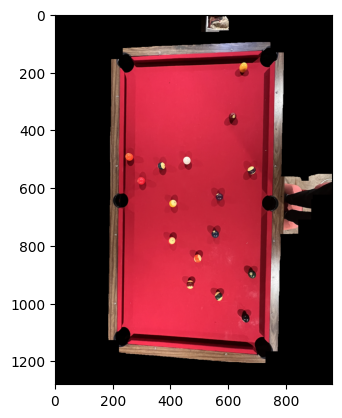

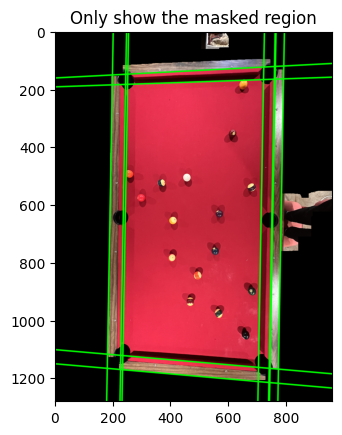

(254, 180)
(237, 1126)
(716, 171)
(699, 1159)


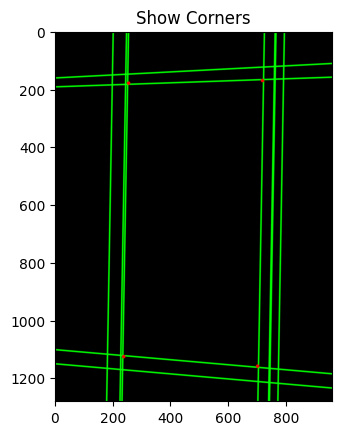

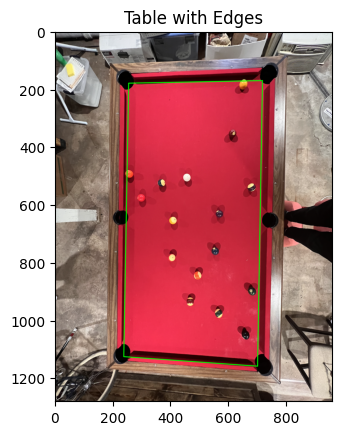

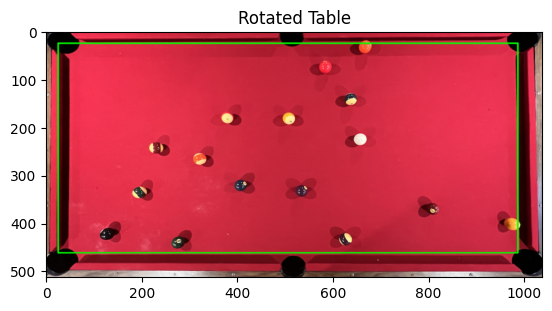

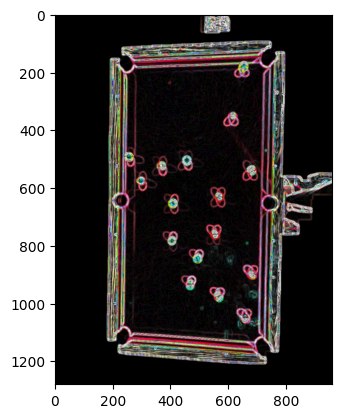

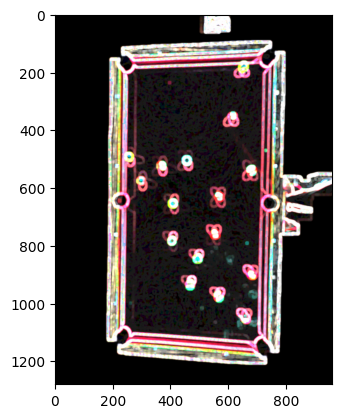

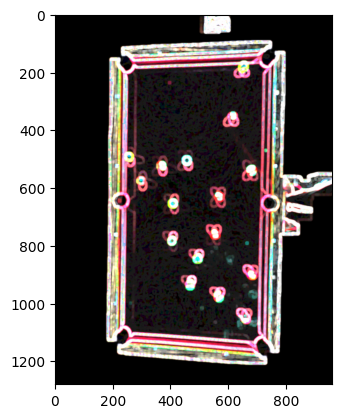

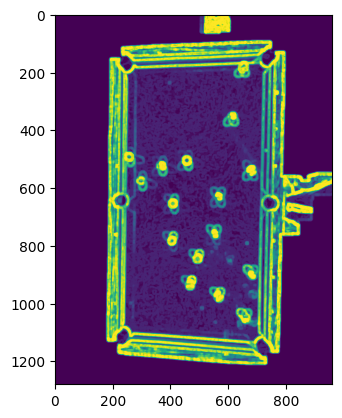

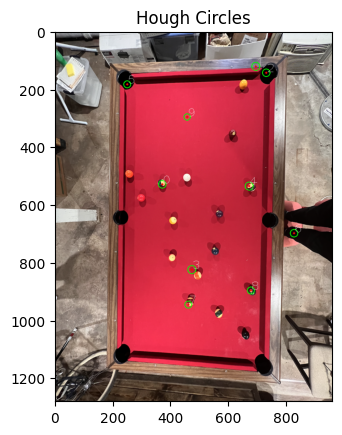

In [21]:
input_dir = './images/all_balls/1280x1280'
output_dir = './new_output_images'
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.startswith('.'): continue
        if not file.startswith('IMG_2735'): continue
        image_path = os.path.join(root, file)
        color = cv2.imread(image_path,1)
        
        # if DEBUG == "ALL":
        #     plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
        #     plt.show()
        masked_img = mask_table(color)
        edges = get_table_edges(masked_img, color)
        cont = contours(masked_img)
        
        # kernel = np.ones((3, 3),np.uint8)
        # cont = cv2.dilate(cont, kernel)
        plt.imshow(cont)
        plt.show()
        # cont = cv2.cvtColor(cont, cv2.COLOR_GRAY2BGR)
        circle_file = os.path.join('.', output_dir, 'circles', file)
        # label_file = os.path.join('.', output_dir, 'labels', file)
        circles = hough_circles(color, cont, circle_file)
        # balls = label_balls(color, circles, label_file)

Limit the image to only the pool table. Credit to Ben.
Perhaps could optimize to use a histogram to progamatically get the color of the felt

https://www.geeksforgeeks.org/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/?ref=rp
Shi-Thomas Corner Detection

(254, 180)
(237, 1126)
(716, 171)
(699, 1159)


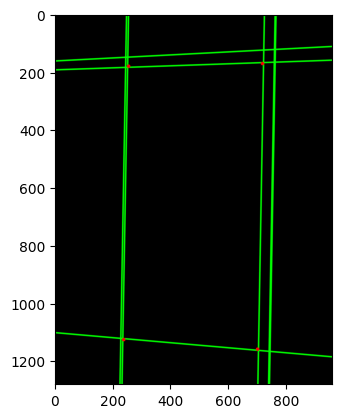

In [29]:
gry_msk_lines = cv2.cvtColor(msk_lines, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gry_msk_lines, 100, 0.01, 10)
msk_lines_out = msk_lines.copy()

corners = np.intp(corners)
h,w, = msk_lines_out.shape[:2]
c1 = [0, 0]
c2 = [0, w]
c3 = [h, 0]
c4 = [h, w]

center = [h/2, w/2]

table_c_dist1 = math.dist(c1, center)
table_c_dist2 = math.dist(c2, center)
table_c_dist3 = math.dist(c3, center)
table_c_dist4 = math.dist(c4, center)

table_cornerUL = c1
table_cornerLL = c2
table_cornerUR = c3
table_cornerLR = c4

for i in corners:
    x, y = i.ravel()
    euc_1 = math.dist(c1,[x,y])
    euc_2 = math.dist(c2,[x,y])
    euc_3 = math.dist(c3,[x,y])
    euc_4 = math.dist(c4,[x,y])

    dist = [euc_1, euc_2, euc_3, euc_4]
    min_euc = min(dist)

    if euc_1 == min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist1:
            table_c_dist1 = euc_cen
            table_cornerUL = (x,y)
    elif euc_2 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist2:
            table_c_dist2 = euc_cen
            table_cornerLL = (x,y)    
    elif euc_3 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist3:
            table_c_dist3 = euc_cen
            table_cornerUR = (x,y) 
    else:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist4:
            table_c_dist4 = euc_cen
            table_cornerLR = (x,y) 
    # find which quadrant
    # draw red color circles on all corners
print(table_cornerUL)
print(table_cornerLL)
print(table_cornerUR)
print(table_cornerLR)

cv2.circle(msk_lines_out, table_cornerUL, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerLL, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerUR, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerLR, 6, (255, 0, 0), -1)

# resulting image
plt.imshow(msk_lines_out)


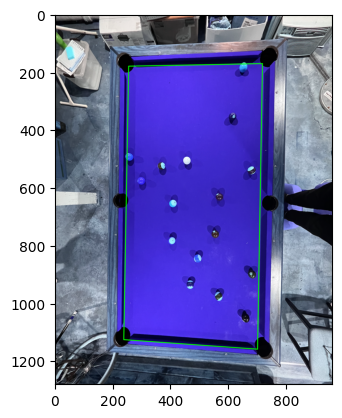

In [30]:
img_draw_box = image1.copy()


cv2.line(img_draw_box, table_cornerUL, table_cornerUR, (0,255,0), 2, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerUR, table_cornerLR, (0,255,0), 2, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerLR, table_cornerLL, (0,255,0), 2, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerLL, table_cornerUL, (0,255,0), 2, cv2.LINE_AA)

plt.imshow(img_draw_box)

https://theailearner.com/tag/cv2-getperspectivetransform/

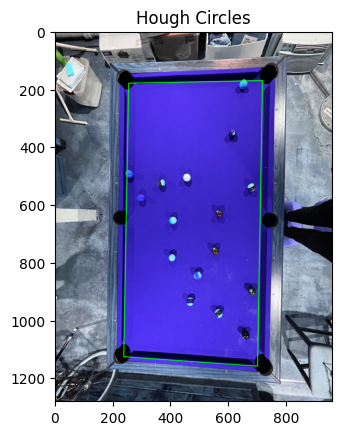

In [31]:
circles = hough_circles(img_draw_box, '')
cimg = img_draw_box
# k = 0
# for i in circles[0,:]:
#     # draw the outer circle
#     cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
#     # draw the center of the circle
#     cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
#     cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
#     k+=1
plt.imshow(cimg)



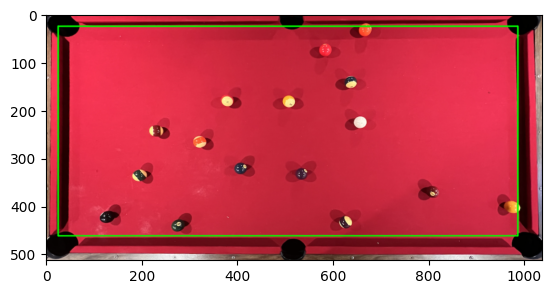

In [32]:
src_cor = np.float32([table_cornerLL, table_cornerLR, table_cornerUR, table_cornerUL])
width_1 = math.dist(table_cornerLL, table_cornerUL)
width_2 = math.dist(table_cornerLR, table_cornerUR)
max_width = max(int(width_1), int(width_2))
edge_width = 25
height_1 = math.dist(table_cornerLL, table_cornerLR)
height_2 = math.dist(table_cornerUL, table_cornerUR)
max_height = max(int(height_1), int(height_2))
dst_corLL = [edge_width, edge_width]
dst_corLR = [edge_width, max_height - 1]
dst_corUR = [max_width - 1, max_height - 1]
dst_corUL = [max_width - 1, edge_width]
dst_cor = np.float32([dst_corLL, dst_corLR, dst_corUR, dst_corUL])

M = cv2.getPerspectiveTransform(src_cor, dst_cor)
rotated_table = cv2.warpPerspective(img_draw_box,M,(max_width+(2*edge_width), max_height+(2*edge_width)),flags=cv2.INTER_LINEAR)
final_out = cv2.cvtColor(rotated_table, cv2.COLOR_BGR2RGB)

cv2.imwrite('./table.png', cv2.cvtColor(final_out, cv2.COLOR_BGR2RGB))
plt.imshow(final_out)

In [33]:
# circles = hough_circles(final_out, '')
# cimg = final_out
# k = 0
# for i in circles[0,:]:
#     # draw the outer circle
#     cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
#     # draw the center of the circle
#     cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
#     cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
#     k+=1
# plt.imshow(cimg)

463 988


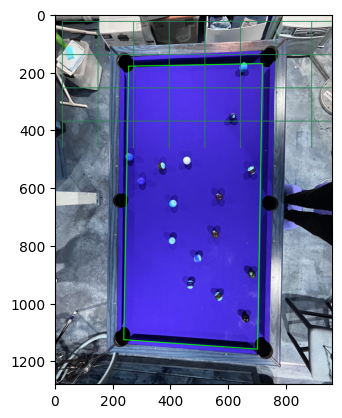

In [34]:
print(max_height, max_width)
table_height = 4
table_width = 8
gridline_h = math.floor(max_height/table_height)
gridline_w = math.floor(max_width/table_width)

x = dst_corLL[0]
y = dst_corLL[1]

while y < max_height:
    cv2.line(cimg, (edge_width, y), (max_width, y), (44, 130, 87), 2)
    y+= gridline_h

while x < max_width:
    cv2.line(cimg, (x, edge_width), (x, max_height), (44, 130, 87), 2)
    x+= gridline_w

plt.imshow(cimg)

